In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import georinex as gr
import xarray as xr
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In many ephemeris entries, the SISA and health fields are swapped (probably a bug in some receiver). The function below is used to detect when this happens and undo the swap.

In [2]:
def fix_SISA_health_swap(eph):
    for sv in eph.coords['sv']:
        swapped = ((np.fmod(eph.sel(sv = sv)['health'], 1) != 0) & ~np.isnan(eph.sel(sv = sv)['health'])) \
            | (eph.sel(sv = sv)['health'] == -1)
        sisa = np.copy(eph.sel(sv = sv)['SISA'][swapped])
        eph.sel(sv = sv)['SISA'][swapped] = eph.sel(sv = sv)['health'][swapped]
        eph.sel(sv = sv)['health'][swapped] = sisa

In [3]:
def plot_ephtimes(ephs):
    plt.figure(figsize = (10,12), facecolor = 'w')
    for sv in ephs.coords['sv']:
        if sv.item()[0] == 'E':
            eph_times = ephs.sel(sv = sv)['IODnav'].dropna('time').coords['time'].values
            plt.plot(eph_times, int(sv.item()[1:3])*np.ones(eph_times.size), '.', color = 'C0')
    plt.yticks(np.arange(1,37), [f'E{svn:02d}' for svn in range(1,37)])
    plt.grid()
    plt.ylabel('SVN')
    plt.xlabel('GST time')
    plt.title('Ephemeris availability')

def plot_SISA(ephs, freq_pair = 'E5b,E1', timesel = None):
    sisa_table = [-1, 0, 3.12]
    freq_pair_bit = {'E5a,E1' : 1 << 8, 'E5b,E1' : 1 << 9}
    plt.figure(figsize = (10,12), facecolor = 'w')
    for sv in ephs.coords['sv']:
        if sv.item()[0] == 'E':
            for j,sisa_val in enumerate(sisa_table):
                sisa = ephs.sel(sv = sv)['SISA'].dropna('time')
                datasrc = np.int32(ephs.sel(sv = sv)['DataSrc'].dropna('time').values) & freq_pair_bit[freq_pair] != 0
                sisa = sisa[datasrc]
                sisa = sisa.coords['time'][sisa == sisa_val]
                plt.plot(sisa, int(sv.item()[1:3])*np.ones(sisa.size), '.', color = f'C{j}')
    plt.yticks(np.arange(1,37), [f'E{svn:02d}' for svn in range(1,37)])
    plt.grid()
    plt.ylabel('SVN')
    plt.xlabel('GST time')
    plt.title(f'SISA {freq_pair} (blue = undefined/unknown, orange = 0, green = 3.12m)')
    
def plot_DVS(ephs, band = 'E1B'):
    dvs_bit = {'E1B' : 1 << 0, 'E5a' : 1 << 3, 'E5b' : 1 << 6}
    dvs_src = {'E1B' : 1 << 0 | 1 << 2, 'E5a' : 1 << 1, 'E5b' : 1 << 0 | 1 << 2}
    plt.figure(figsize = (10,12), facecolor = 'w')
    for sv in ephs.coords['sv']:
        if sv.item()[0] == 'E':
            dvs = ephs.sel(sv = sv)['health'].dropna('time')
            datasrc = np.int32(ephs.sel(sv = sv)['DataSrc'].dropna('time').values) & dvs_src[band] != 0
            dvs = dvs[datasrc]
            dvs_set = np.int32(dvs) & dvs_bit[band] != 0
            dvs_1 = dvs.coords['time'][dvs_set].values
            dvs_0 = dvs.coords['time'][~dvs_set].values
            plt.plot(dvs_0, int(sv.item()[1:3])*np.ones(dvs_0.size), '.', color = 'green')
            plt.plot(dvs_1, int(sv.item()[1:3])*np.ones(dvs_1.size), '.', color = 'red')
    plt.yticks(np.arange(1,37), [f'E{svn:02d}' for svn in range(1,37)])
    plt.grid()
    plt.ylabel('SVN')
    plt.xlabel('GST time')
    plt.title(f'{band} DVS (green = nav data valid, red = working w/o guarantee)')

def plot_HST(ephs, band = 'E1B'):
    hst_shift = {'E1B' : 1, 'E5a' : 4, 'E5b' : 7}
    hst_src = {'E1B' : 1 << 0 | 1 << 2, 'E5a' : 1 << 1, 'E5b' : 1 << 0 | 1 << 2}
    plt.figure(figsize = (10,12), facecolor = 'w')
    for sv in ephs.coords['sv']:
        if sv.item()[0] == 'E':
            hst = ephs.sel(sv = sv)['health'].dropna('time')
            datasrc = np.int32(ephs.sel(sv = sv)['DataSrc'].dropna('time').values) & hst_src[band] != 0
            hst = hst[datasrc]
            hst_val = (np.int32(hst) >> hst_shift[band]) & 0x3
            color = ['green', 'red', 'orange', 'blue']
            for h in range(4):
                hh = hst.coords['time'][hst_val == h].values
                plt.plot(hh, int(sv.item()[1:3])*np.ones(hh.size), '.', color = color[h])
    plt.yticks(np.arange(1,37), [f'E{svn:02d}' for svn in range(1,37)])
    plt.grid()
    plt.ylabel('SVN')
    plt.xlabel('GST time')
    plt.title(f'{band} HST (green = OK, red = out of service, orange = will be out of service, blue = in test)')

def all_plots(eph):
    plot_ephtimes(eph)
    plot_SISA(eph, freq_pair = 'E5a,E1')
    plot_SISA(eph, freq_pair = 'E5b,E1')
    plot_DVS(eph, band = 'E5a')
    plot_DVS(eph, band = 'E5b')
    plot_DVS(eph, band = 'E1B')
    plot_HST(eph, band = 'E5a')
    plot_HST(eph, band = 'E5b')
    plot_HST(eph, band = 'E1B')

In [4]:
control = gr.load('BRDC00IGS_R_20191800000_01D_MN.rnx.gz')
fix_SISA_health_swap(control)
recovery = xr.merge((gr.load('BRDC00IGS_R_20191970000_01D_MN.rnx.gz'), gr.load('BRDC00IGS_R_20191980000_01D_MN.rnx.gz')))
fix_SISA_health_swap(recovery)

List all the different SISA values that appear in the ephemeris. Usually -1 (NAPA), 0 and 3.12m appear.

In [5]:
x = np.ravel(xr.merge((control, recovery))['SISA'].values)
x = x[~np.isnan(x)]
np.unique(x)

array([-1.  ,  0.  ,  3.12])

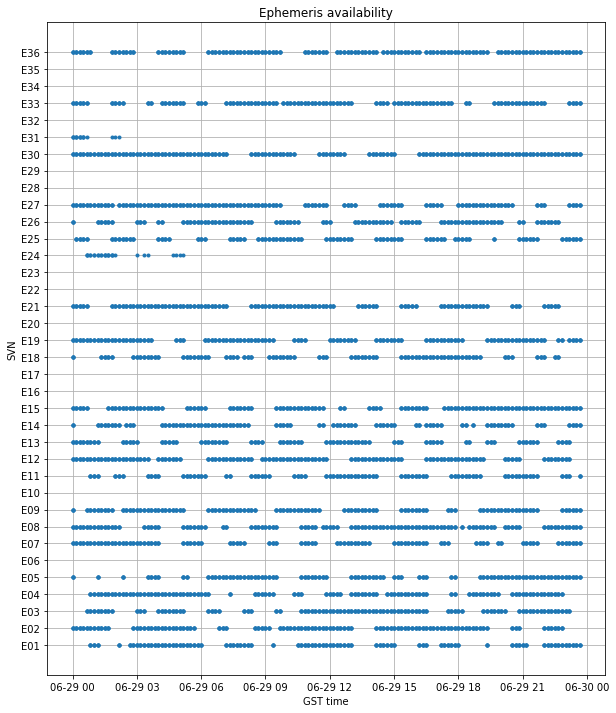

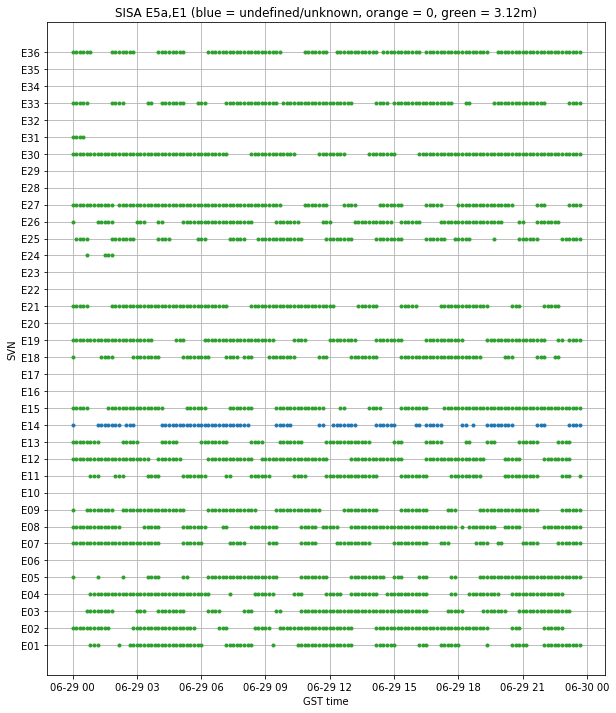

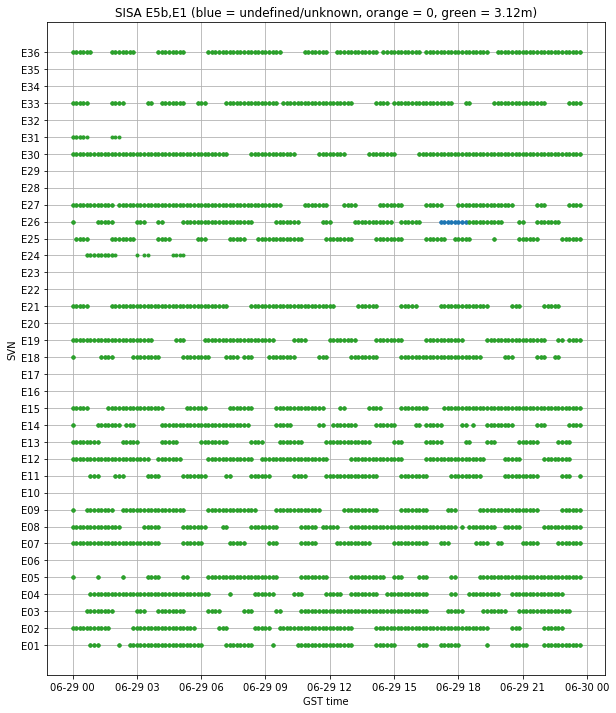

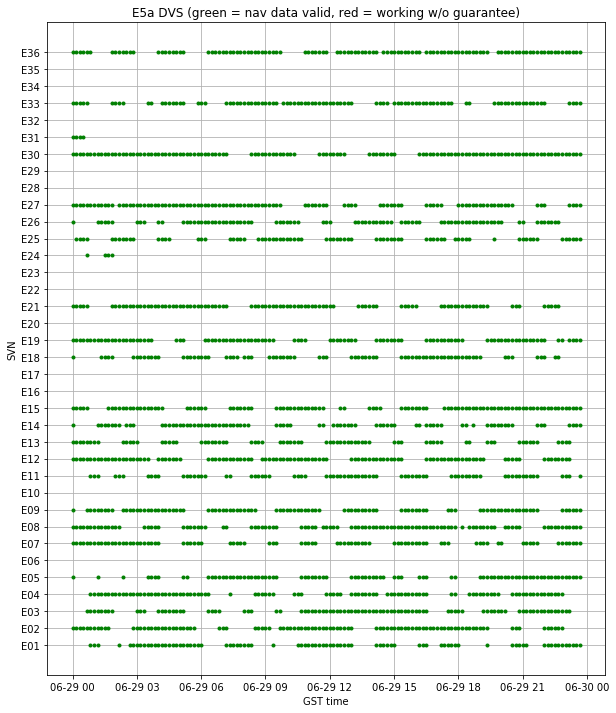

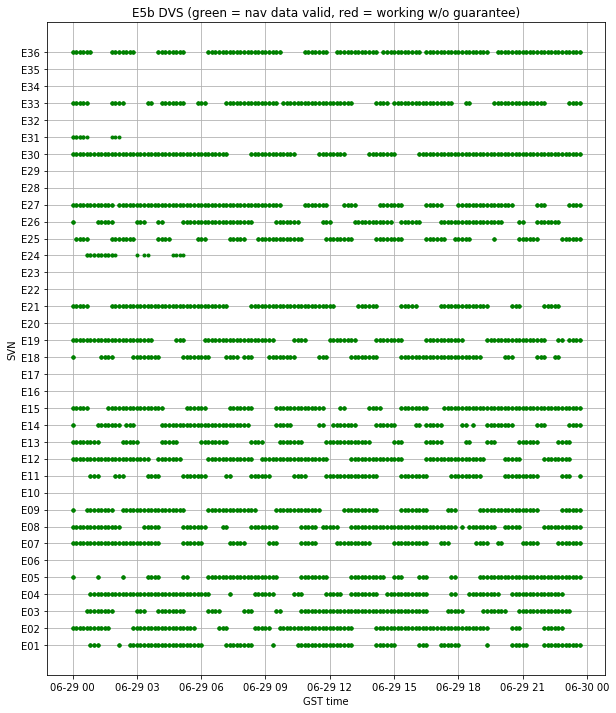

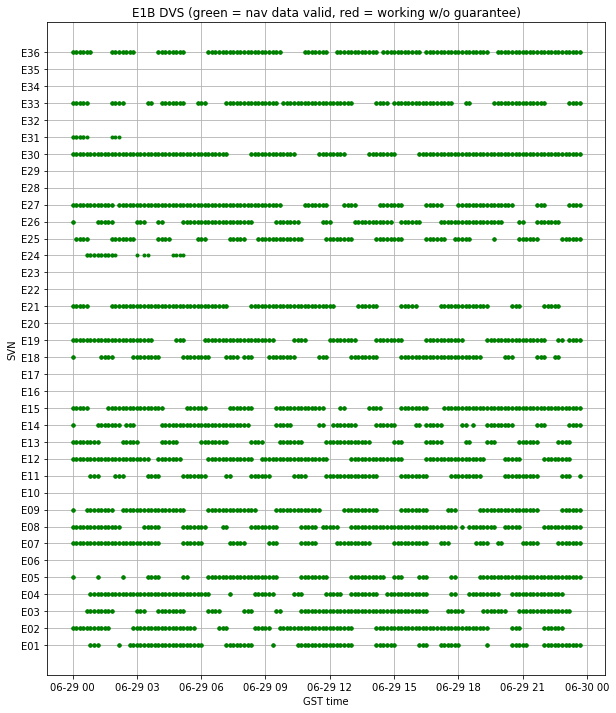

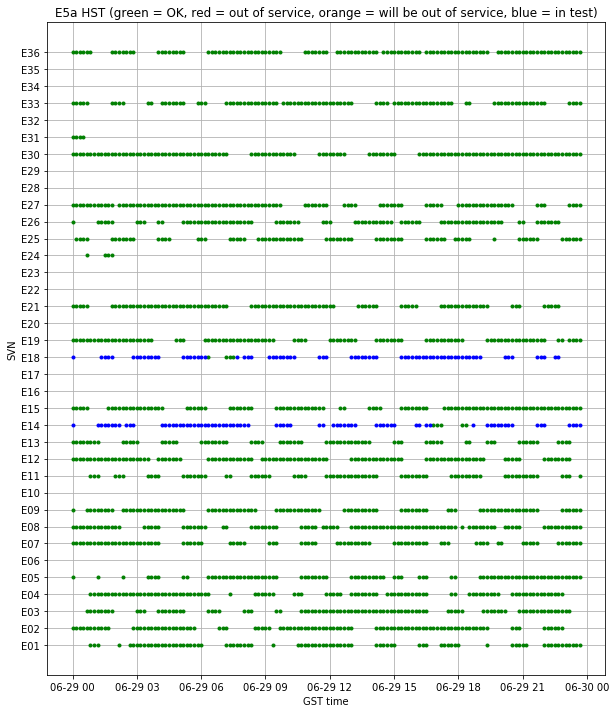

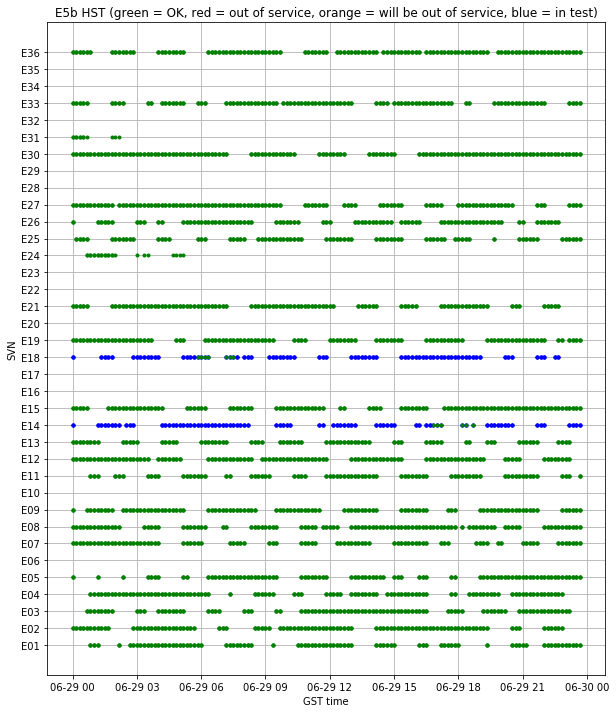

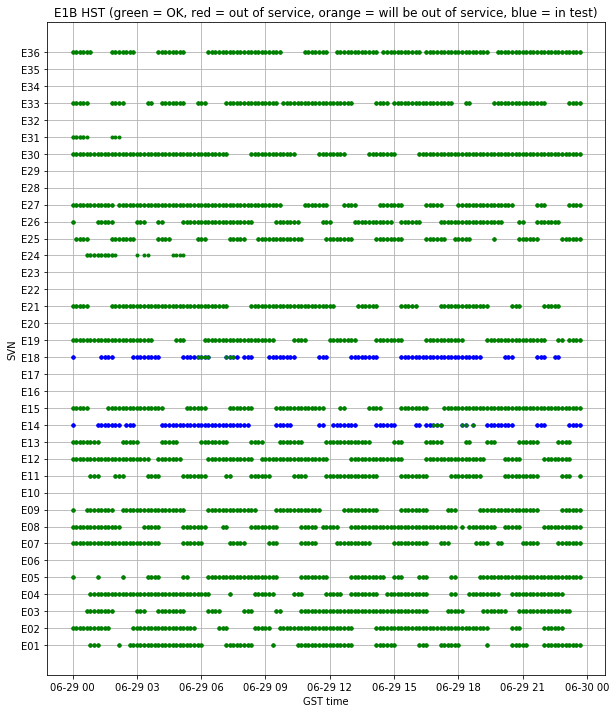

In [6]:
all_plots(control)

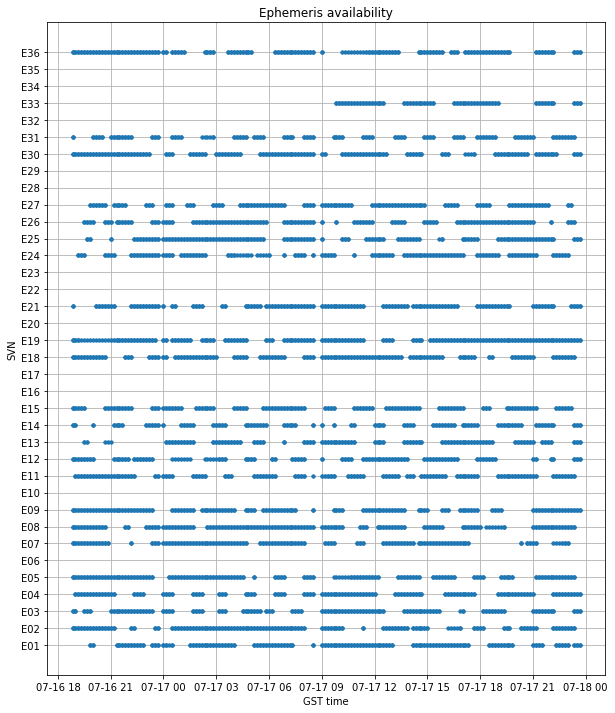

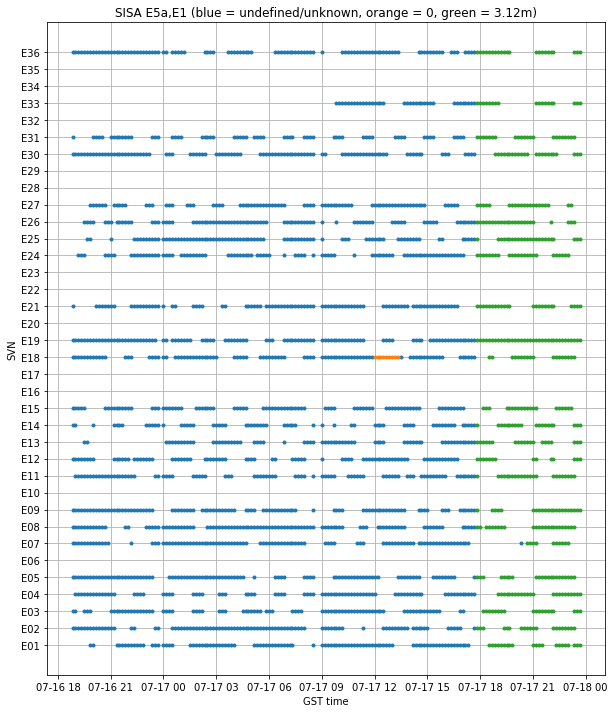

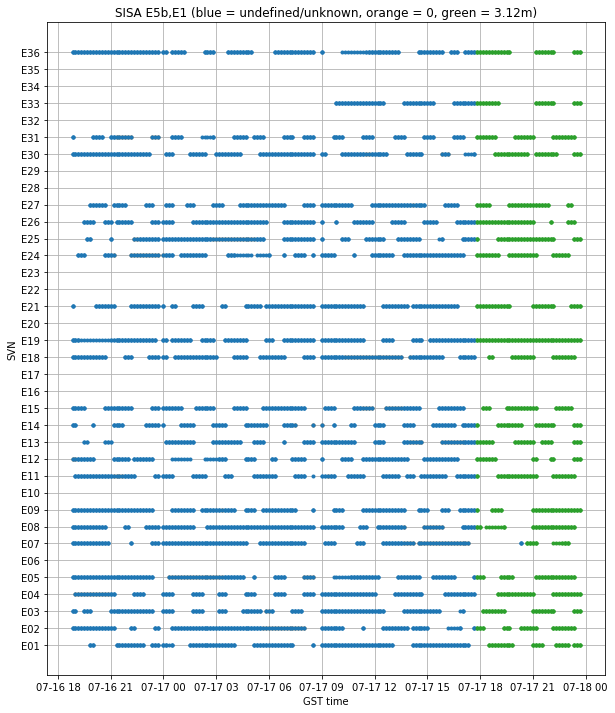

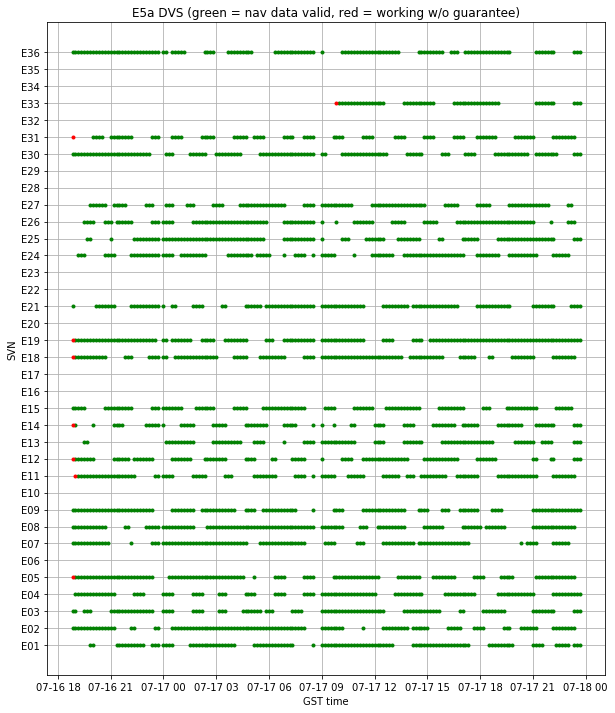

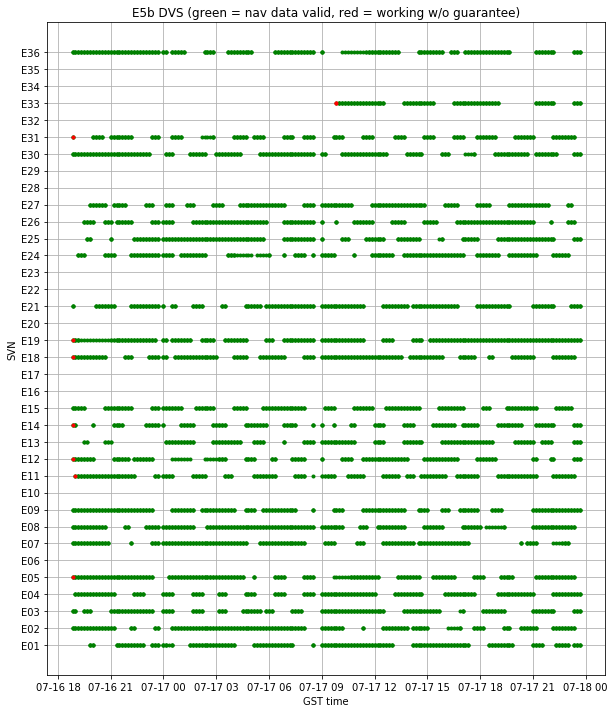

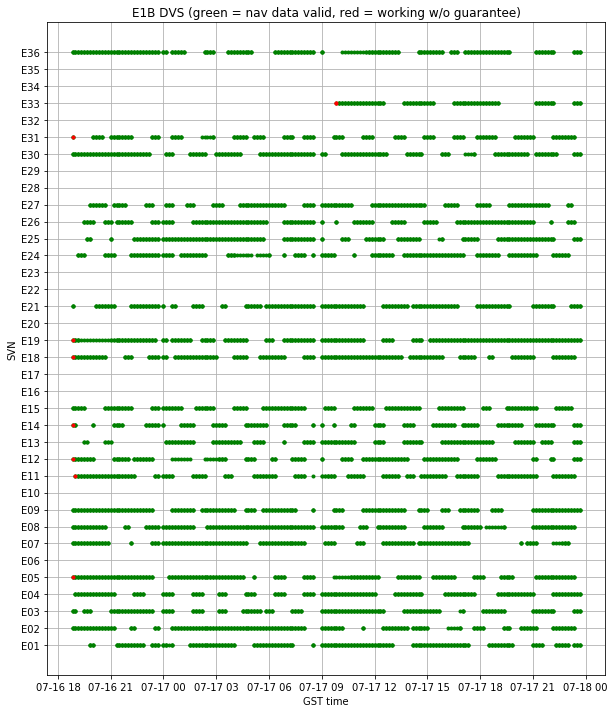

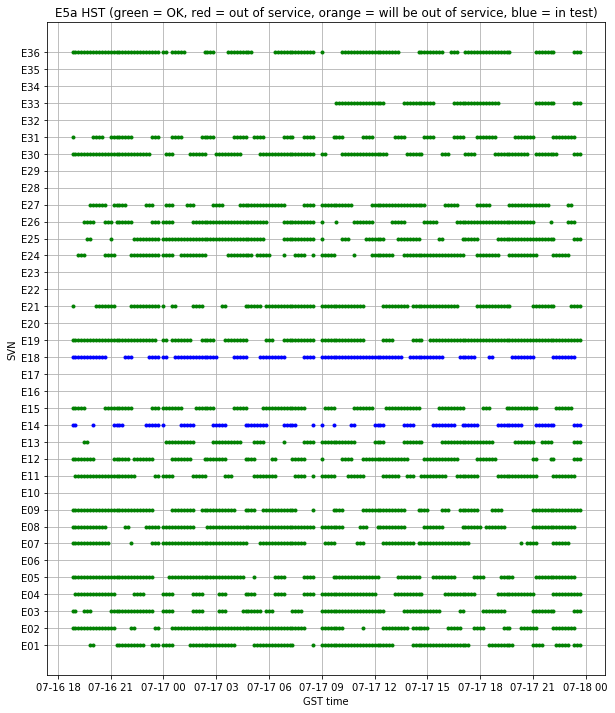

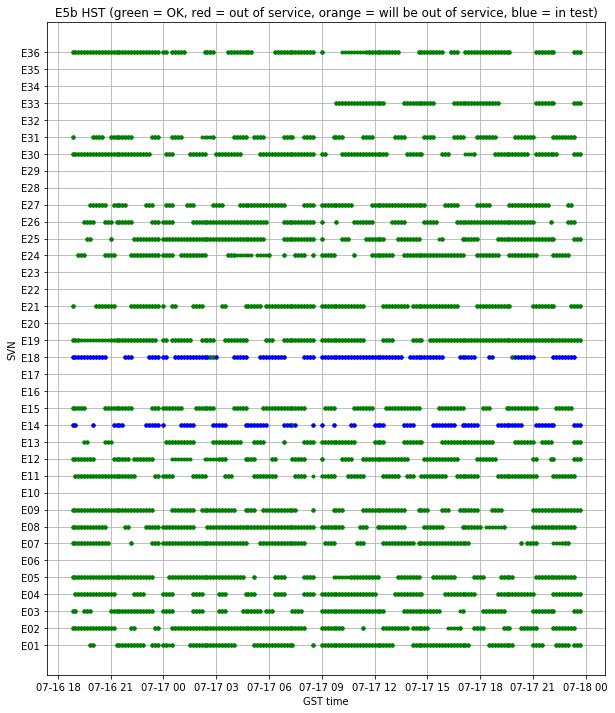

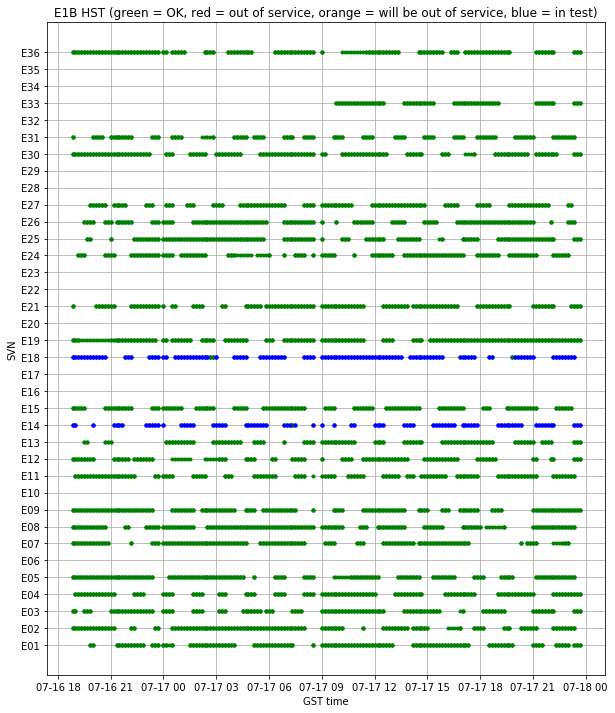

In [7]:
all_plots(recovery)

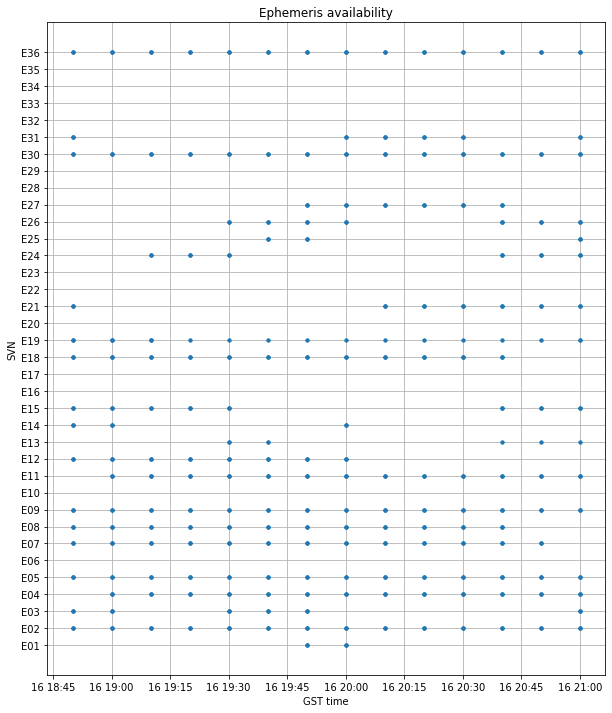

In [8]:
plot_ephtimes(recovery.sel(time = slice('2019-07-16 18:00', '2019-07-16 21:00')))

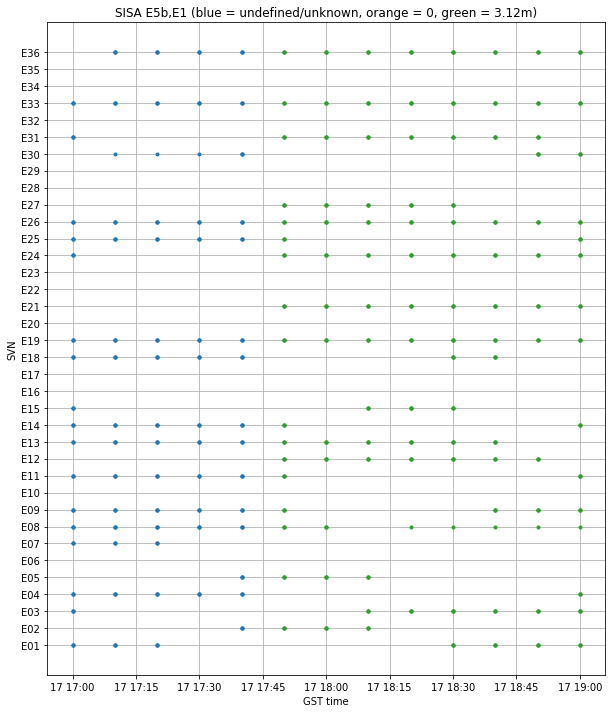

In [9]:
plot_SISA(recovery.sel(time = slice('2019-07-17 17:00', '2019-07-17 19:00')))

Below there is some information about the gaps in the ephemeris. The IODnav is increased every 10 minutes, and usually every sequential IODnav appears in the RINEX, but for some reason some IODnav's are skipped (either in the RINEX or in the signal in space).

Text(0, 0.5, 'IODnav')

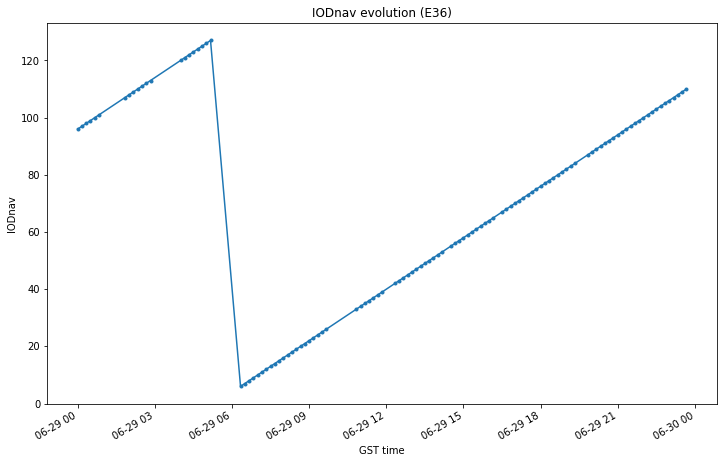

In [10]:
plt.figure(figsize = (12, 7))
control.sel(sv = 'E36')['IODnav'].dropna('time').plot(marker = '.')
plt.title('IODnav evolution (E36)')
plt.xlabel('GST time')
plt.ylabel('IODnav')

In [11]:
control.sel(sv = 'E36')['IODnav'].dropna('time')[:20]

<xarray.DataArray 'IODnav' (time: 20)>
array([ 96.,  97.,  98.,  99., 100., 101., 107., 108., 109., 110., 111., 112.,
       113., 120., 121., 122., 123., 124., 125., 126.])
Coordinates:
    sv       <U5 'E36'
  * time     (time) datetime64[ns] 2019-06-29 ... 2019-06-29T05:00:00

In [12]:
control.sel(sv = 'E36')['IODnav'].dropna('time').coords['time'][:20]

<xarray.DataArray 'time' (time: 20)>
array(['2019-06-29T00:00:00.000000000', '2019-06-29T00:10:00.000000000',
       '2019-06-29T00:20:00.000000000', '2019-06-29T00:30:00.000000000',
       '2019-06-29T00:40:00.000000000', '2019-06-29T00:50:00.000000000',
       '2019-06-29T01:50:00.000000000', '2019-06-29T02:00:00.000000000',
       '2019-06-29T02:10:00.000000000', '2019-06-29T02:20:00.000000000',
       '2019-06-29T02:30:00.000000000', '2019-06-29T02:40:00.000000000',
       '2019-06-29T02:50:00.000000000', '2019-06-29T04:00:00.000000000',
       '2019-06-29T04:10:00.000000000', '2019-06-29T04:20:00.000000000',
       '2019-06-29T04:30:00.000000000', '2019-06-29T04:40:00.000000000',
       '2019-06-29T04:50:00.000000000', '2019-06-29T05:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    sv       <U5 'E36'
  * time     (time) datetime64[ns] 2019-06-29 ... 2019-06-29T05:00:00